# SEI and SEIS Model Implementations

The current stable of models does not include the less common SEI and SEIS models. In this notebook we will implement the required components for these models.

## SEI

We can use the common Susceptible component.

We will need a new Exposed component which transitions agents from exposed to infectious when the incubation timer expired but does not set an infectious duration timer.

We can use the Infectious component from the SI model.

We can use the Transmission component from the SEIR/SEIRS models which knows to transition susceptible agents into exposed agents upon infection.

In [6]:
from laser.generic.models.SI import Susceptible, Infectious
from laser.generic.models.SEIR import Transmission

Let's look at the source for the Exposed `__init__()` function.

In [7]:
from laser.generic.models.SEIR import Exposed
import inspect

print(inspect.getsource(Exposed.__init__))

    def __init__(self, model, expdurdist, infdurdist, expdurmin=1, infdurmin=1):
        self.model = model
        self.model.people.add_scalar_property("etimer", dtype=np.uint16)
        self.model.nodes.add_vector_property("E", model.params.nticks + 1, dtype=np.int32)
        self.model.nodes.add_vector_property("newly_infectious", model.params.nticks + 1, dtype=np.int32)

        self.model.nodes.E[0] = self.model.scenario.E

        self.expdurdist = expdurdist
        self.infdurdist = infdurdist
        self.expdurmin = expdurmin
        self.infdurmin = infdurmin

        # convenience
        nodeids = self.model.people.nodeid
        states = self.model.people.state

        for node in range(self.model.nodes.count):
            nseeds = self.model.scenario.E[node]
            if nseeds > 0:
                i_susceptible = np.nonzero((nodeids == node) & (states == State.SUSCEPTIBLE.value))[0]
                assert nseeds <= len(i_susceptible), (
                    f"Node {n

Let's look at the source for the Exposed `step()` function.

In [8]:

print(inspect.getsource(Exposed.step))


    def step(self, tick: int) -> None:
        # Propagate the number of exposed individuals in each patch
        # state(t+1) = state(t) + ∆state(t), initialize state(t+1) with state(t)
        self.model.nodes.E[tick + 1] = self.model.nodes.E[tick]

        newly_infectious_by_node = np.zeros((nb.get_num_threads(), self.model.nodes.count), dtype=np.int32)
        # self.nb_exposed_step(
        #     self.model.people.state,
        #     self.model.people.etimer,
        #     self.model.people.itimer,
        #     newly_infectious_by_node,
        #     self.model.people.nodeid,
        #     self.infdurdist,
        #     self.infdurmin,
        #     tick,
        # )
        nb_timer_update_timer_set(
            self.model.people.state,
            State.EXPOSED.value,
            self.model.people.etimer,
            State.INFECTIOUS.value,
            self.model.people.itimer,
            newly_infectious_by_node,
            self.model.people.nodeid,
            self.infdu

Let's look at the source for the Exposed nb_exposed_step() function.

In [9]:
print(inspect.getsource(Exposed.nb_exposed_step))

    def postvalidate_step(self, tick: int) -> None:
        _check_flow_vs_census(self.model.nodes.E[tick + 1], self.model.people, State.EXPOSED, "Exposed")
        _check_timer_active(self.model.people.state, State.EXPOSED.value, self.model.people.etimer, "Exposed", "etimer")
        _check_state_timer_consistency(self.model.people.state, State.EXPOSED.value, self.model.people.etimer, "Exposed", "etimer")

        assert np.all(self.model.people.state[self.etimers_one] == State.INFECTIOUS.value), (
            "Individuals with etimer == 1 before should now be infectious."
        )
        assert np.all(self.model.people.etimer[self.etimers_one] == 0), "Individuals with etimer == 1 before should now have etimer == 0."
        assert np.all(self.model.people.itimer[self.etimers_one] > 0), "Individuals with etimer == 1 before should now have itimer > 0."

        return



We will implement a new ExposedSEI class which overrides the functions in the SEIR Exposed component.

In [10]:
import numba as nb
import numpy as np
from laser.generic.models.SI import State

# Implement a new nb_exposed_step() function which tests the state and etimer and transitions the agent to the INFECTIOUS state when the timer expires. This function will not take itimers, infdurdist, infdurmin, or tick parameters and will not set an infectious duration timer. The function should use Numba's njit decorator for performance and prange to parallelize over agents.
# Implement a new step() function, modeled after the SEIR model Exposed step(), which updates the node count E, calls the new nb_exposed_step() function with an accumulation array - newly_infectious - and updates the node E and I counters.

class ExposedSEI(Exposed):

    def __init__(self, model, expdurdist, expdurmin=1):
        # We only need the incubation (exposure) duration distribution parameters during initialization.
        super().__init__(model, expdurdist, infdurdist=None, expdurmin=expdurmin, infdurmin=None)

        return

    @staticmethod
    @nb.njit(nogil=True, parallel=True)
    def nb_exposed_step(states, etimers, newly_infectious_by_node, nodeids) -> None:
        for i in nb.prange(states.shape[0]):
            if states[i] == State.EXPOSED.value:
                etimers[i] -= 1
                if etimers[i] <= 0:
                    states[i] = State.INFECTIOUS.value
                    newly_infectious_by_node[nb.get_thread_id(), nodeids[i]] += 1

        return
    
    def step(self, tick: int) -> None:
        # Propagate the number of exposed individuals in each patch
        # state(t+1) = state(t) + ∆state(t), initialize state(t+1) with state(t)
        self.model.nodes.E[tick + 1] = self.model.nodes.E[tick]

        newly_infectious_by_node = np.zeros((nb.get_num_threads(), self.model.nodes.count), dtype=np.int32)
        self.nb_exposed_step(
            self.model.people.state,
            self.model.people.etimer,
            newly_infectious_by_node,
            self.model.people.nodeid,
        )
        newly_infectious_by_node = newly_infectious_by_node.sum(axis=0).astype(self.model.nodes.S.dtype)  # Sum over threads

        # state(t+1) = state(t) + ∆state(t)
        self.model.nodes.E[tick + 1] -= newly_infectious_by_node
        self.model.nodes.I[tick + 1] += newly_infectious_by_node
        # Record today's ∆
        self.model.nodes.newly_infectious[tick] = newly_infectious_by_node

        return

## Single Node Suite

Let's run 10 simulations with $10^6$ agents each.

Scenario 10/10 (seed=89): 100%|██████████| 365/365 [00:00<00:00, 2188.35it/s]


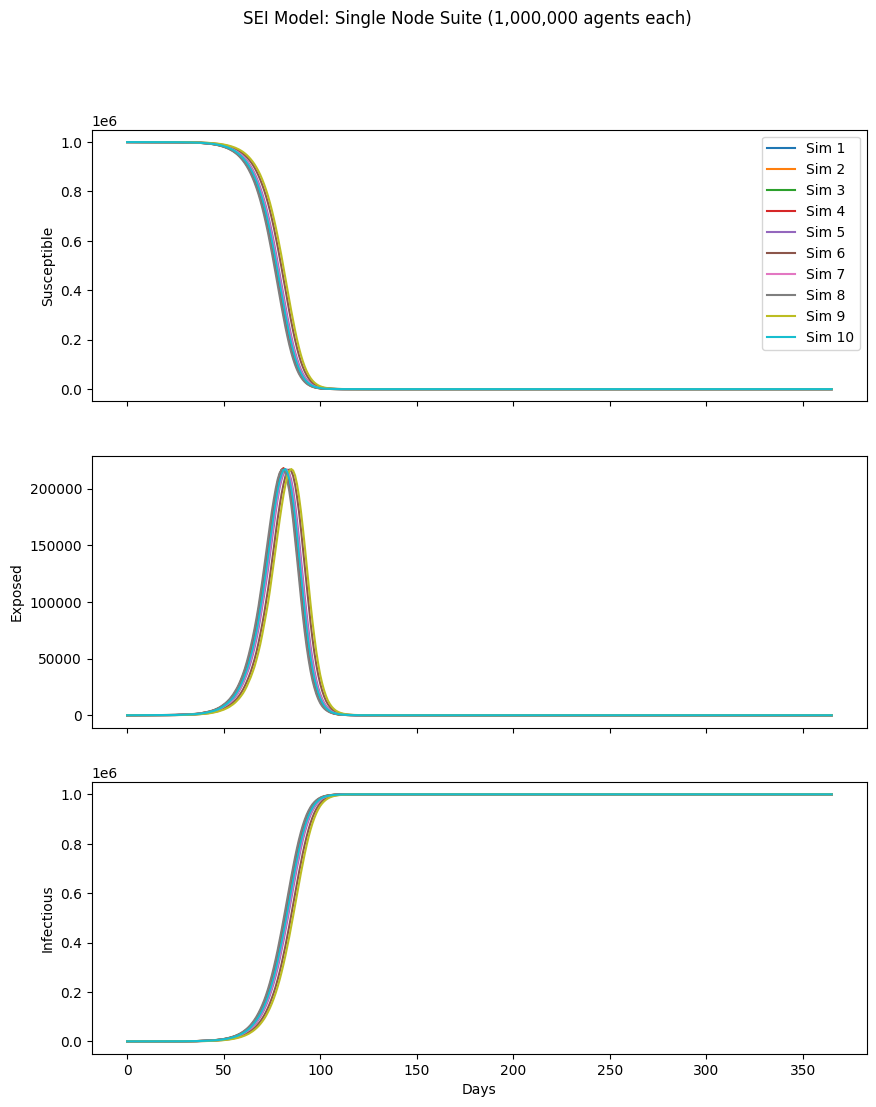

In [28]:
from laser.core.utils import grid
from laser.core.random import seed as set_seed
from laser.generic.models.model import Model
from laser.core import PropertySet
from laser.core.distributions import normal

initial_infectious = 10
seeds = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89]
nticks = 365

scenario = grid(M=1, N=1, node_size_degs=0.1, population_fn=lambda x, y: 1_000_000)
scenario["S"] = scenario.population - initial_infectious
scenario["E"] = 0
scenario["I"] = initial_infectious

results_sei = []
for i, seed in enumerate(seeds):
    set_seed(seed)
    model = Model(scenario, params=PropertySet({"beta": 0.3, "seed": seed, "nticks": nticks}), skip_capacity=True)
    exposure_duration = normal(loc=5, scale=1.5)
    model.components = [
        Susceptible(model),
        Infectious(model),  # Infectious goes _before_ Exposed so the previous I count is propagated before the Exposed step updates it.
        ExposedSEI(model, expdurdist=exposure_duration, expdurmin=1),
        Transmission(model, expdurdist=exposure_duration, expdurmin=1),
    ]

    model.run(f"Scenario {i+1:2}/{len(seeds)} (seed={seed:2})")
    results_sei.append((model.nodes.S, model.nodes.E, model.nodes.I))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
for i, (S, E, I) in enumerate(results_sei):
    ax[0].plot(S.sum(axis=1), label=f"Sim {i+1}")
    ax[1].plot(E.sum(axis=1), label=f"Sim {i+1}")
    ax[2].plot(I.sum(axis=1), label=f"Sim {i+1}")
ax[0].set_ylabel("Susceptible")
ax[1].set_ylabel("Exposed")
ax[2].set_ylabel("Infectious")
ax[2].set_xlabel("Days")
ax[0].legend()
plt.suptitle("SEI Model: Single Node Suite (1,000,000 agents each)")
plt.show()


Let's run 10 SI models with same R0 for comparison.

Scenario 10/10 (seed=89): 100%|██████████| 365/365 [00:00<00:00, 4455.79it/s]


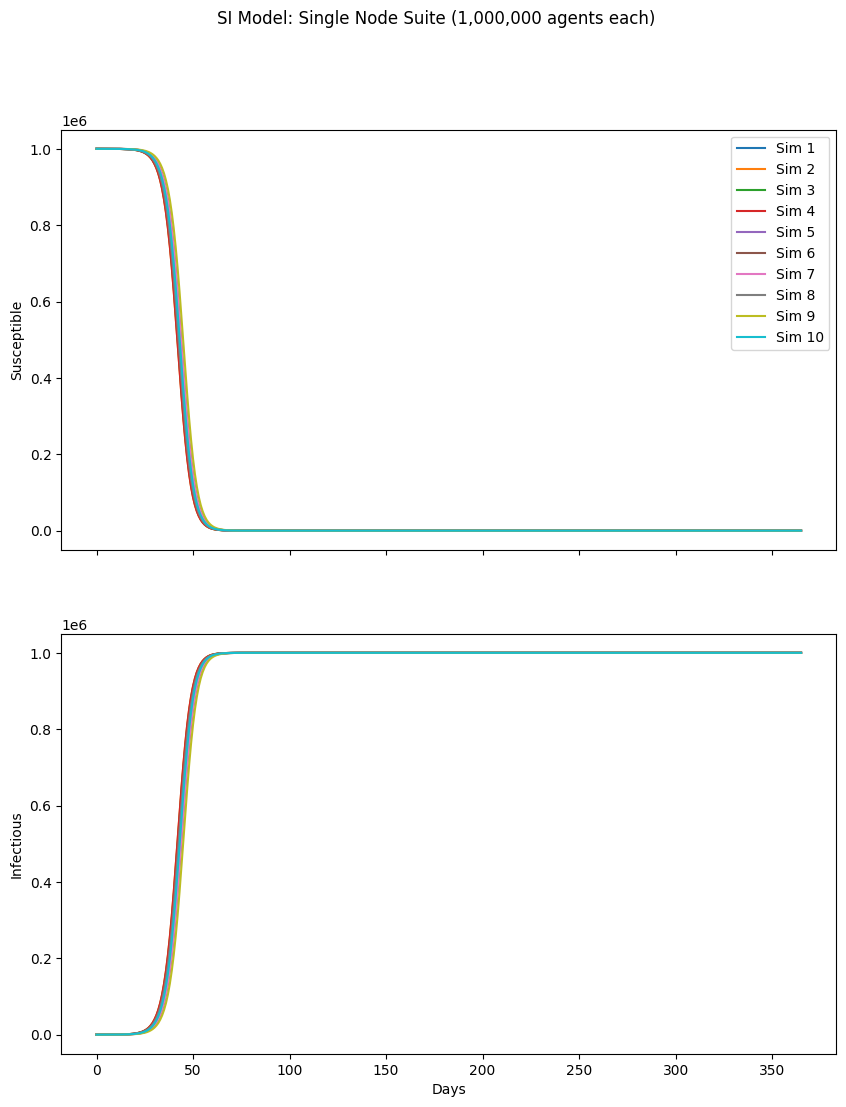

In [26]:
import laser.generic.models.SI as SI

# Let's run 10 SI models with same R0 for comparison.
results_si = []
for i, seed in enumerate(seeds):
    set_seed(seed)
    model = Model(scenario, params=PropertySet({"beta": 0.3, "seed": seed, "nticks": nticks}), skip_capacity=True)
    exposure_duration = normal(loc=5, scale=1.5)
    model.components = [
        SI.Susceptible(model),
        SI.Infectious(model),
        SI.Transmission(model),
    ]

    model.run(f"Scenario {i+1:2}/{len(seeds)} (seed={seed:2})")
    results_si.append((model.nodes.S, model.nodes.I))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
for i, (S, I) in enumerate(results_si):
    ax[0].plot(S.sum(axis=1), label=f"Sim {i+1}")
    ax[1].plot(I.sum(axis=1), label=f"Sim {i+1}")
ax[0].set_ylabel("Susceptible")
ax[1].set_ylabel("Infectious")
ax[1].set_xlabel("Days")
ax[0].legend()
plt.suptitle("SI Model: Single Node Suite (1,000,000 agents each)")
plt.show()


Let's plot a comparison between the two.

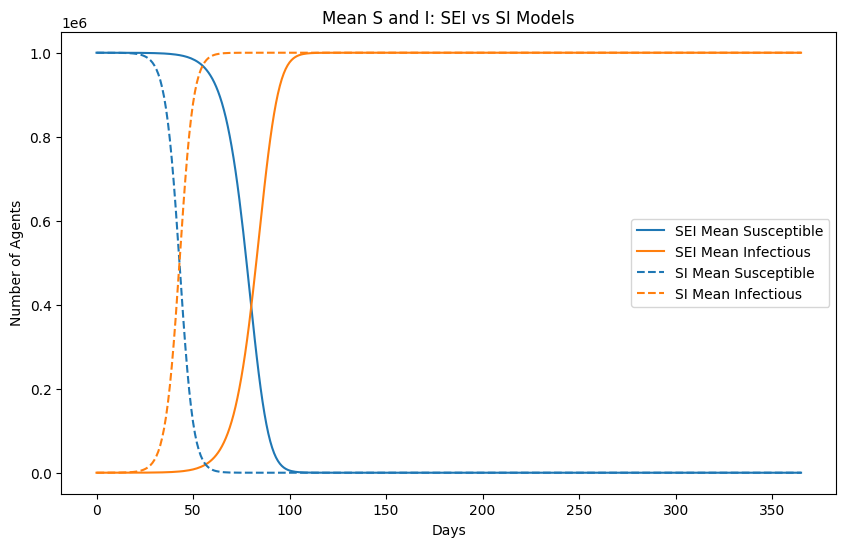

In [29]:
import numpy as np

import matplotlib.pyplot as plt

# Compute mean S and I for SEI model
S_sei = np.array([S for S, E, I in results_sei])  # shape: (n_sim, n_time, 1)
I_sei = np.array([I for S, E, I in results_sei])
mean_S_sei = S_sei.mean(axis=0).squeeze()
mean_I_sei = I_sei.mean(axis=0).squeeze()

# Compute mean S and I for SI model
S_si = np.array([S for S, I in results_si])
I_si = np.array([I for S, I in results_si])
mean_S_si = S_si.mean(axis=0).squeeze()
mean_I_si = I_si.mean(axis=0).squeeze()

plt.figure(figsize=(10, 6))
plt.plot(mean_S_sei, label="SEI Mean Susceptible", color="tab:blue")
plt.plot(mean_I_sei, label="SEI Mean Infectious", color="tab:orange")
plt.plot(mean_S_si, label="SI Mean Susceptible", color="tab:blue", linestyle="--")
plt.plot(mean_I_si, label="SI Mean Infectious", color="tab:orange", linestyle="--")
plt.xlabel("Days")
plt.ylabel("Number of Agents")
plt.title("Mean S and I: SEI vs SI Models")
plt.legend()
plt.show()

As expected, the SEI model takes longer to get started due to the delay imposed by the incubation period (exposed state).